## This is my attempt to use martin's data creation technique and then put it in Siamene Network using Fast AI. I am using following links for this:
https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563/output
https://github.com/radekosmulski/whale/blob/master/siamese_network_prototype.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Suppress annoying stderr output when importing keras.
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')

sys.stderr = old_stderr

import random
from scipy.ndimage import affine_transform

import pickle
import numpy as np
from math import sqrt

# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

from pandas import read_csv
import pandas as pd

In [3]:
df = pd.read_csv('data/train.csv')
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')

For training data, we are taking all the images except for the category - New Whale

In [4]:
new_df = df[df['Id']!= 'new_whale']
#new_df = new_df[new_df['sighting_count']>1]

print('shape of data for training ',new_df.shape)
new_df.drop(columns = ['sighting_count'] , inplace=True)
new_df.head(2)

shape of data for training  (15697, 3)


/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a


In [5]:
new_df.reset_index(inplace=True)
new_df.drop(columns='index' , inplace=True)
new_df.tail(3)

,Image,Id
15694,fff7faf61.jpg,w_9cf0388
15695,fff9002e0.jpg,w_bd1c3d5
15696,fffcde6fe.jpg,w_9f30885


In [6]:
"""
The data set we are using for training contains all images except of new whales.
we don't require creating phase values for this  datasets , as duplicate images are very few.
i am using index present in train.csv as the phase value as we can use it for indexing very easily 
"""

tagged = dict([(p,w) for _,p,w in new_df.to_records()])
h2ps = dict([(idx , p ) for   idx,p,w in new_df.to_records()])
p2h   = dict([(p , idx) for idx , p , w in new_df.to_records()])
h2p = h2ps.copy()
join = tagged.copy()

In [7]:
#def expand_path(p):
#    if isfile('data/train-224/' + p): return 'data/train-224/' + p
#    if isfile('data/test-224/' + p): return 'data/test-224/' + p
#    return p
#
#p2size = {}
#for p in tqdm_notebook(join):
#    size      = pil_image.open(expand_path(p)).size
#    p2size[p] = size
#len(p2size), list(p2size.items())[:5]

In [8]:
## phase value for all categories except new whale
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

15697

In [9]:
## for each whale category, observe the associated phase values , 
##store all whale categories even the categories with just one image ( this is  different from martin's approach)

w2hs = {}
val_fns = []

for h,ws in h2ws.items():
    if len(ws) == 1: # Use only unambiguous pictures
        w = ws[0]
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
            
for w,hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)
    else:
        val_fns.append(df.Image[df.Id == w].tolist()[0])
len(w2hs), len(val_fns)

(5004, 2073)

In [10]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    return img


import matplotlib.pyplot as plt

In [11]:
train = [] # A list of  indices of images to be used in training data.
valid = [] # A list of  indices of images to be used in validation data.
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
    else:
        valid += hs
        
random.shuffle(train)
random.shuffle(valid)

train_set = set(train)
valid_set = set(valid)

In [12]:
len(train_set), len(valid_set)

(13624, 2073)

In [13]:
## we have whales categories with phases(images) more than 1. shuffle the phase values now.
#Associate the image index from train to each whale id.

w2ts = {} 
val_w2ts = {}

for w,hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts: w2ts[w] = []
            if h not in w2ts[w]: w2ts[w].append(h)
        if h in valid_set:
            if w not in val_w2ts: val_w2ts[w] = []
            if h not in val_w2ts[w]: val_w2ts[w].append(h)
                
for w,ts in w2ts.items(): 
    if (len(ts)>1):
        w2ts[w] = np.array(ts)
    else:
        val_w2ts[w] = np.array(ts)
    
## then again for each whale categories see how many images you have , 
## you are working with 5004 whale categories and 15697 images 
    
    
t2i = {} # The position in train of each training image id
for i,t in enumerate(train): 
    t2i[t] = i
    
val_t2i = {} # The position in validation of each training image id
for i,t in enumerate(valid): 
    val_t2i[t] = i

len(w2ts), len(val_w2ts), len(t2i), len(val_t2i)

(2931, 2073, 13624, 2073)

In [14]:
len(t2i), len(train), max(list(t2i.keys())) 

(13624, 13624, 15695)

In [15]:
# from keras.utils import Sequence
# import keras

from IPython.core.debugger import set_trace
import random
#from keras import backend as K

try:
    from lap import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment


Import functions from fast ai library

In [16]:
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *
from torch.utils.data import DataLoader, Dataset
from torch import nn
from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

from IPython.core.debugger import set_trace
from functional import seq

In [17]:
name = f'resnet18_martin'

fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}  
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [18]:
def path2valid(path):
    return True if path.split('/')[-1] in val_fns else False

In [19]:
SZ = 224
BS = 64
NUM_WORKERS = 8
SEED=0

Creating dataset for all the training images. Because of some reason , i am not able to create validation set as well ( produces error while indexing from match and unmatch matrices. If someone is able to find the work arounf the help will be appreciated

In [20]:
classes = df.Id.unique()
data = (
    ImageItemList  ##df[(df.Id != 'new_whale') & (df.sighting_count >1)]
        .from_df(df[(df.Id != 'new_whale')], f'data/train-{SZ}', cols=['Image'])
        #.no_split()
        .split_by_valid_func(lambda path: path2valid(path)) 
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(max_lighting=0.3, max_zoom=1., do_flip=False), 
                   size=SZ, resize_method=ResizeMethod.SQUISH))

In [21]:
#data.train.x.convert_mode = 'L'
#data.valid.x.convert_mode = 'L'
#data.test.x.convert_mode = 'L'

In [22]:
print(len(data.train.x), len(train))
print(len(data.valid.x), len(valid))
print(len(data.test.x))

13624 13624
2073 2073
7960


## Calculate mean/std

In [23]:
#import PIL
#from PIL import ImageStat

In [24]:
#paths = np.append(np.append(data.train.x.items, data.valid.x.items), data.test.x.items)

In [25]:
#means = torch.zeros(3)
#stds = torch.zeros(3) 
#
#count =  len(paths)
#count

In [26]:
#means

In [27]:
#for i, fname in enumerate(paths):    
#    img = Image(pil2tensor(PIL.Image.open(fname).convert('RGB'),np.float32).div_(255)).data
#    #print(img.shape)
#    means += torch.Tensor([torch.mean(img[0]),torch.mean(img[1]),torch.mean(img[2])])
#    stds += torch.Tensor([torch.std(img[0]),torch.std(img[1]),torch.std(img[2])])
#    if i % 10000 == 0: print(i)
#
#mean = means/count
#std = stds/count
#mean, std

In [28]:
#([0.5175, 0.5562, 0.6008], [0.2160, 0.2171, 0.2212])

TwoImDataset creation is the part where I am trying to replicate 'TrainingData Class' from https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563/output
For whale categories having just one images in training data , matching pair -  same image pair (A,A) . For other categories it creates a de arrangement.  

In [29]:
def is_even(num): return num % 2 == 0

class TwoImDataset(Dataset):
    def __init__(self, ds, score, datasetType, steps = 1000):
        self.ds = ds
        self.datasetType = datasetType
        self.whale_ids = ds.y.items
        self.steps = 1000
        self.score  = -score
        if self.datasetType == DatasetType.Train:
            for ts in w2ts.values():
                idxs = [t2i[t] for t in ts] #ts.copy() 
                for i in idxs:
                    for j in idxs:
                        self.score[i,j] = 10000.0   # Set a large value for matching
        else:
            for ts in val_w2ts.values():
                idxs = [val_t2i[t] for t in ts] #ts.copy() 
                for i in idxs:
                    for j in idxs:
                        self.score[i,j] = 10000.0   # Set a large value for matching
            
        self.on_epoch_end()
        
    def __len__(self):
        return 2 * len(self.ds)
    def __getitem__(self, idx):
        if is_even(idx):
            return self.sample_image(idx // 2, 1)
        else: return self.sample_image((idx-1) // 2, 0)        

    def sample_image(self, idx , tag):
        #set_trace()
        if tag==0:
            first_image_id =  self.match[idx][0]
            second_image_id = self.match[idx][1]        
            return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 1)
        else:
            first_image_id =  self.unmatch[idx][0]
            second_image_id = self.unmatch[idx][1]  
            return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 0)
  
    def on_epoch_end(self):
        if self.steps <= 0: return # Skip this on the last epoch.
        self.steps     -= 1
        self.match      = []
        self.unmatch    = []
        if segment:
            tmp   = []
            batch = 512
            for start in range(0, score.shape[0], batch):
                end = min(score.shape[0], start + batch)
                _, x = linear_sum_assignment(self.score[start:end, start:end])
                tmp.append(x + start)
            x = np.concatenate(tmp)
        else:
            _,_,x = lapjv(self.score) # Solve the linear assignment problem
        y = np.arange(len(x),dtype=np.int32)
        
        if self.datasetType == DatasetType.Train:
            # Compute a derangement for matching whales
            for ts in w2ts.values():
                _ts = [t2i[t] for t in ts] #ts.copy()
                d = _ts.copy()
                if (len(d)==1):
                    for ab in zip(_ts,d): 
                        self.match.append(ab)
                else:                
                    while True:
                        random.shuffle(d)
                        if not np.any(_ts == d): break
                    for ab in zip(_ts,d): 
                        self.match.append(ab)

            # Construct unmatched whale pairs from the LAP solution.
            for i,j in zip(x,y):
                assert i != j
                self.unmatch.append((t2i[train[i]],t2i[train[j]]))
        else:
            # Compute a derangement for matching whales
            for val_ts in val_w2ts.values():
                _val_ts = [val_t2i[t] for t in val_ts] #val_ts.copy()
                d = _val_ts.copy()
                if (len(d)==1):
                    for ab in zip(_val_ts,d): self.match.append(ab)
                else:                
                    while True:
                        random.shuffle(d)
                        if not np.any(_val_ts == d): break
                    for ab in zip(_val_ts,d): self.match.append(ab)

            # Construct unmatched whale pairs from the LAP solution.
            for i,j in zip(x,y):
                assert i != j
                self.unmatch.append((val_t2i[valid[i]],val_t2i[valid[j]]))
            
        # Force a different choice for an eventual next epoch.
        self.score[x,y] = 10000.0
        self.score[y,x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
    
    def construct_example(self, im_A, im_B, class_idx):
        #print('imgA: '+str(im_A.shape))
        #print('imgB: '+str(im_B.shape))
        return [im_A, im_B], class_idx

In [30]:
"""
Create a 2D score matrix of size of training data
"""

score = np.random.random_sample(size=(len(train),len(train)))

train_dl = DataLoader(
    TwoImDataset(data.train, score, DatasetType.Train), 
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

valid_score = np.random.random_sample(size=(len(val_fns),len(val_fns)))

valid_dl = DataLoader(
    TwoImDataset(data.valid, valid_score, DatasetType.Valid), 
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

In [31]:
stats = ([0.5175, 0.5562, 0.6008], [0.2160, 0.2171, 0.2212])

In [32]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [33]:
data_bunch = ImageDataBunch(train_dl, train_dl)
data_bunch.add_tfm(normalize_batch) #normalize_batch

In [34]:
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    def __init__(self, learn:Learner, monitor:str='val_loss', mode:str='auto'):
        super().__init__(learn)
        self.monitor,self.mode = monitor,mode
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__class__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]

    def on_train_begin(self, **kwargs:Any)->None:
        "Initializes the best value."
        self.best = float('inf') if self.operator == np.less else -float('inf')

    def get_monitor_value(self):
        "Pick the monitored value."
        if self.monitor=='trn_loss' and len(self.learn.recorder.losses) == 0: return None
        elif len(self.learn.recorder.val_losses) == 0: return None
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=self.learn.recorder.metrics[-1:][0][i]
        if values.get(self.monitor) is None:
            warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')
        return values.get(self.monitor)

In [35]:
class SaveModel(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='val_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')

    def on_train_end(self, **kwargs):
        "Load the best model."
        if self.every=="improvement" and (self.learn.path/f'{self.learn.model_dir}/{self.name}.pth').is_file():
            self.learn.load(f'{self.name}')

In [36]:
"""
The network architecture is also inspired from Martin's notebook (part after we extract features for two image pairs)
"""
class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        
        self.cnn = create_body(arch)
        self.head = nn.Linear(num_features_model(self.cnn), 1)  
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size= (1,  4), padding = 0, stride=1)
        self.conv2 = nn.Conv2d(1, 1, kernel_size = (32, 1), padding = 0, stride=1)

    def forward(self, im_A, im_B):
        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)
        d1 = self.calculate_distance(x1, x2)
        d2 = (x1 + x2)
        d3 = (x1*x2)
        d4 = (x1-x2)*(x1 - x2)
        concat_layer = torch.cat([d1 ,d2,d3, d4]  ,dim = 1)
        concat_layer = concat_layer.view(-1, 1, num_features_model(self.cnn), 4)
        concat_layer  = F.relu(self.conv1(concat_layer))
        concat_layer = concat_layer.view(-1, 1, 32, num_features_model(self.cnn))
        concat_layer = F.relu(self.conv2(concat_layer))
        concat_layer_fn = concat_layer.view(-1, num_features_model(self.cnn))
        out = self.head(concat_layer_fn)
        return out
    
    def process_features(self, x): 
        y = x.reshape(*x.shape[:2], -1)
        return x.reshape(*x.shape[:2], -1).max(-1)[0]
    def calculate_distance(self, x1, x2): return (x1 - x2).abs_()

In [37]:
#from functional import seq
#
#class SiameseNetwork(nn.Module):
#    def __init__(self, arch=models.resnet34, pooling_layer=nn.AdaptiveMaxPool2d):
#        super().__init__()
#        
#        #Body
#        self.cnn = create_body(arch)
#        #self.cnn[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#        
#        #Head
#        mid = 32
#        
#        self.conv1 = nn.Sequential(*[conv2d(4, mid, stride=(1,4)), nn.ReLU(inplace=True)])
#        self.conv2 = nn.Sequential(*[conv2d(mid, 1, stride=(1,mid)), Flatten()])
#        
#        self.fc = nn.Linear(512, 1, bias=True)
#
#    def forward(self, im_A, im_B):
#        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.pooling)
#        dist = self.calculate_features(x1, x2)
#        feat = self.process_features(dist)
#        con1 = self.conv1(feat)
#        con2 = self.conv2(con1)
#        out = self.fc(con2)
#        return out
#
#    def calculate_features(self, x1, x2):
#        mu = x1 * x2
#        ad = x1 + x2
#        mi = torch.abs(x1-x2)
#        sq = mi**2
#        x = torch.cat([mu, ad, mi, sq], dim=1)
#        return x
#
#    def process_features(self, x):
#        return x.view(x.shape[0], 4, 512, 1)
#
#    def pooling(self, x):
#        return F.max_pool2d(x, kernel_size=x.size()[2:])

In [38]:
torch.backends.cudnn.benchmark = True

In [39]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [40]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), callback_fns=[ShowGraph], 
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [41]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.conv1])

In [42]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [43]:
learn.freeze_to(-1)

In [44]:
learn.lr_find()
learn.recorder.plot()

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/multiprocessing/connection.py", lin

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(1 , 1e-3)

epoch,train_loss,valid_loss,


In [48]:
learn.save(f'{name}-{SZ}-stage-1')

In [49]:
#learn.load(f'{name}-{SZ}-stage-1');

In [50]:
learn.unfreeze()

In [51]:
max_lr = 2e-4
lrs = slice(max_lr/90, max_lr)
learn.lr_range(lrs)

array([2.222222e-06, 2.108185e-05, 2.000000e-04])

In [52]:
learn.callback_fns.append(partial(SaveModel, every='epoch', name=f'{name}-{SZ}-stage-2'))

epoch,train_loss,valid_loss,
1,0.699755,0.539339,0.846117
2,0.693773,0.487333,0.919440
3,0.689494,0.423162,0.966233
4,0.685067,0.351611,0.988905
5,0.674502,0.395832,0.947902
6,0.675810,0.329492,0.992041
7,0.670658,0.343247,0.974674
8,0.656128,0.281256,0.986011
9,0.636499,0.316171,0.951037
10,0.625659,0.434392,0.842499


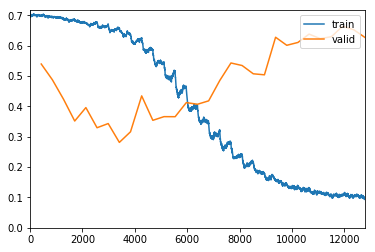

In [53]:
learn.fit_one_cycle(30, lrs, div_factor=40)

epoch,train_loss,valid_loss,
1,0.691733,0.461305,0.952726
2,0.685945,0.409310,0.977086
3,0.689139,0.389934,0.986493
4,0.673844,0.353713,0.987217
5,0.677367,0.349398,0.991558
6,0.671297,0.364488,0.985769
7,0.661705,0.331101,0.973710
8,0.657854,0.376575,0.940183
9,0.642903,0.389780,0.901833
10,0.620844,0.366414,0.903521


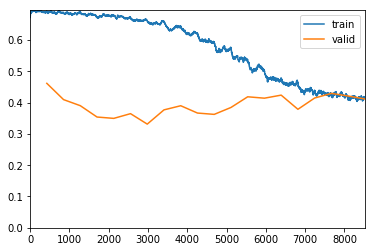

In [54]:
learn.fit_one_cycle(20, lrs, div_factor=40)

## Size 448px

In [54]:
SZ = 2*224
BS = 16
NUM_WORKERS = 8

In [55]:
classes = df.Id.unique()
data = (
    ImageItemList  ##df[(df.Id != 'new_whale') & (df.sighting_count >1)]
        .from_df(df[(df.Id != 'new_whale')], f'data/train-{SZ}', cols=['Image'])
        #.no_split()
        .split_by_valid_func(lambda path: path2valid(path)) 
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(max_lighting=0.3, max_zoom=1., do_flip=False), 
                   size=SZ, resize_method=ResizeMethod.SQUISH))

In [56]:
"""
Create a 2D score matrix of size of training data
"""

score = np.random.random_sample(size=(len(train),len(train)))

train_dl = DataLoader(
    TwoImDataset(data.train, score, DatasetType.Train), 
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

valid_score = np.random.random_sample(size=(len(val_fns),len(val_fns)))

valid_dl = DataLoader(
    TwoImDataset(data.valid, valid_score, DatasetType.Valid), 
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

In [57]:
data_bunch = ImageDataBunch(train_dl, valid_dl)
data_bunch.add_tfm(normalize_batch)

In [58]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), callback_fns=[ShowGraph], 
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [59]:
learn.load(f'{name}-224-stage-2_30');

In [60]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.conv1])

In [61]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


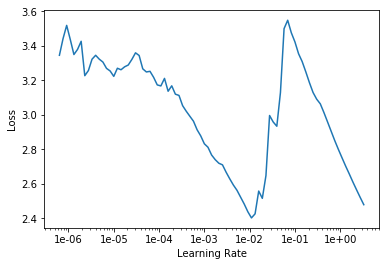

In [62]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,
1,0.691590,0.453370,0.966474


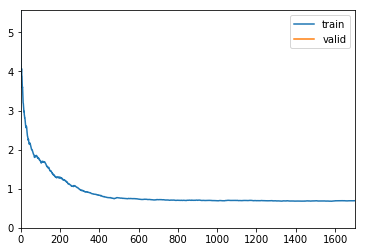

In [63]:
learn.fit_one_cycle(1 , 1e-3)

In [64]:
learn.save(f'{name}-{SZ}-stage-3')

In [65]:
learn.unfreeze()

In [66]:
max_lr = 1e-4
lrs = slice(max_lr/90, max_lr)
learn.lr_range(lrs)

array([1.111111e-06, 1.054093e-05, 1.000000e-04])

In [67]:
learn.callback_fns.append(partial(SaveModel, every='epoch', name=f'{name}-{SZ}-stage-4'))

epoch,train_loss,valid_loss,
1,0.680838,0.447847,0.969850
2,0.686837,0.439948,0.972986
3,0.683800,0.419748,0.977086


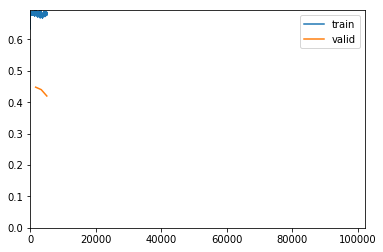

KeyboardInterrupt: 

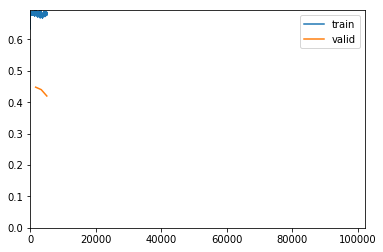

In [68]:
learn.fit_one_cycle(60, lrs, div_factor=100)

## validate

In [130]:
#learn.load(f'{name}-{SZ}-stage-4_22'); #todo add best epoch
learn.load(f'{name}-224-stage-2_20');

In [131]:
new_whale_fns = set(df[df['Id']=='new_whale'].sample(frac = 1).Image.iloc[:1000])
#new_whale_fns

In [133]:
#val_fns = set(df[df.sighting_count == 2].Image)
#print(len(val_fns) + len(new_whale_fns))

classes = df.Id.unique()

df = df.drop(columns = ['sighting_count'])
df.head(2)

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a


In [134]:
def path2valid_new_whales(path):
    return True if path.split('/')[-1] in val_fns.union(new_whale_fns) else False

In [135]:
data = (
    ImageItemList
        .from_df(df, f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2valid_new_whales(path))  ##.union(new_whale_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(max_lighting=0.3, max_zoom=1.), 
                   size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(stats)
)

In [136]:
#model forward for reference:

#x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.pooling)
#dist = self.calculate_features(x1, x2)
#feat = self.process_features(dist)
#con1 = self.conv1(feat)
#con2 = self.conv2(con1)
#out = self.fc(con2)

In [137]:
%%time
targs = []
feats = []
learn.model.eval()
for ims, ts in data.valid_dl:
    feats.append(learn.model.pooling(learn.model.cnn(ims)).detach().cpu())
    targs.append(ts)

feats = torch.cat(feats)
print(feats.shape)

torch.Size([3570, 512, 1, 1])
CPU times: user 3.09 s, sys: 1.99 s, total: 5.08 s
Wall time: 5.29 s


In [138]:
%%time
sims = []
for feat in feats:
    x1 = feats #.copy()
    x2 = feat.unsqueeze(0).repeat(3570,1,1,1)
    x = learn.model.process_features(learn.model.calculate_features(x1, x2))
    con1 = learn.model.conv1(x.cuda())
    con2 = learn.model.conv2(con1)
    predicted_similarity = learn.model.fc(con2).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 2min 7s, sys: 16.7 s, total: 2min 24s
Wall time: 2min 24s


In [139]:
len(sims[0])

3570

In [140]:
new_whale_idx = np.where(classes == 'new_whale')[0][0]
new_whale_idx

3

In [141]:
%%time
top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if len(top_5) == 5: break
        if j == new_whale_idx or j == i: continue
        predicted_class = data.valid_ds.y.items[j]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 1.27 s, sys: 4.21 ms, total: 1.27 s
Wall time: 1.27 s


In [142]:
top_5s[:5]

[[2238, 2346, 3, 1607, 48],
 [2184, 3892, 4103, 2966, 44],
 [3, 4041, 1816, 4380, 4294],
 [1609, 485, 2455, 971, 2189],
 [3, 2979, 659, 700, 4570]]

In [147]:
"""
mapk of validation data set without having new whales in predictions. 
"""
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.28823062558356677

In [148]:
%%time

for thresh in np.linspace(0.95, 1, 21):
    top_5s = []
    for i, sim in enumerate(sims):
        idxs = sim.argsort(descending=True)
        probs = sim[idxs]
        top_5 = []
        for j, p in zip(idxs, probs):
            if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
            if len(top_5) == 5: break
            if j == new_whale_idx or j == i: continue
            predicted_class = data.valid_ds.y.items[j]
            if predicted_class not in top_5: top_5.append(predicted_class)
        top_5s.append(top_5)
    print(thresh, mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5))

0.95 0.1560457516339869
0.9524999999999999 0.1560597572362278
0.955 0.1562231559290383
0.9575 0.1562231559290383
0.96 0.15638655462184875
0.9624999999999999 0.1565266106442577
0.965 0.1568860877684407
0.9675 0.15718954248366016
0.97 0.15739962651727357
0.9724999999999999 0.15818860877684407
0.975 0.15881419234360408
0.9775 0.15973389355742296
0.98 0.16050420168067228
0.9824999999999999 0.1622362278244631
0.985 0.1652894491129785
0.9875 0.169733893557423
0.99 0.1766293183940243
0.9924999999999999 0.18818394024276375
0.995 0.2061998132586368
0.9975 0.2327357609710551
1.0 0.28823062558356677
CPU times: user 30 s, sys: 19.9 ms, total: 30 s
Wall time: 30 s


## Predict

In [149]:
BS=64

In [150]:
data = (
    ImageItemList
        .from_df(df, f'data/train-{SZ}', cols=['Image'])
        #.no_split()
        .split_by_valid_func(lambda path: path2valid(path))
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(None, size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [151]:
%%time
test_feats = []
learn.model.eval()
for ims, _ in data.test_dl:
    test_feats.append(learn.model.pooling(learn.model.cnn(ims)).detach().cpu())
    
test_feats = torch.cat(test_feats)

CPU times: user 6.74 s, sys: 4.03 s, total: 10.8 s
Wall time: 11.2 s


In [153]:
%%time
sims = []
for feat in feats:
    x1 = feats #.copy()
    x2 = feat.unsqueeze(0).repeat(3570,1,1,1)
    x = learn.model.process_features(learn.model.calculate_features(x1, x2))
    con1 = learn.model.conv1(x.cuda())
    con2 = learn.model.conv2(con1)
    predicted_similarity = learn.model.fc(con2).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

KeyboardInterrupt: 

In [ ]:
%%time
train_feats = []
train_class_idxs = []
learn.model.eval()
for ims, t in data.train_dl:
    train_feats.append(learn.model.pooling(learn.model.cnn(ims)).detach().cpu())
    train_class_idxs.append(t)
    
train_class_idxs = torch.cat(train_class_idxs)
train_feats = torch.cat(train_feats)

In [ ]:
len(train_class_idxs), len(train_feats)

In [ ]:
#del ts, t, ims, data_bunch, feats, feat, top_5s

In [ ]:
#del predicted_similarity, concat_layer_fn, concat_layer, x1, x2, d1, d2, d3, d4, predicted_class

In [ ]:
#gc.collect()

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
#torch.cuda.memory_cached()

In [ ]:
#torch.cuda.memory_allocated()

In [ ]:
!nvidia-smi

In [94]:
%%time
sims = []
for feat in test_feats:
    x1 = train_feats #.copy()
    x2 = feat.unsqueeze(0).repeat(25344,1,1,1)
    x = learn.model.process_features(learn.model.calculate_features(x1, x2))
    con1 = learn.model.conv1(x.cuda())
    con2 = learn.model.conv2(con1)
    predicted_similarity = learn.model.fc(con2).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 29min 23s, sys: 19min 42s, total: 49min 5s
Wall time: 49min 10s


In [102]:
%%time
thresh = 0.95

top_5s = []
for sim in sims:
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for i, p in zip(idxs, probs):
        if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
        if len(top_5) == 5: break
        if i == new_whale_idx: continue
        predicted_class = train_class_idxs[i]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 21.2 s, sys: 413 ms, total: 21.6 s
Wall time: 21.6 s


In [103]:
top_5_classes  = []

for top_5 in top_5s:
    top_5_classes.append(' '.join([classes[t] for t in top_5]))

In [104]:
top_5_classes[:5]

['w_6ca173f new_whale w_ff3efba w_3108dce w_343f088',
 'w_1b1dd05 new_whale w_6e7763b w_cbda0d3 w_ab44c81',
 'w_384e3b2 new_whale w_8f1069a w_b9edd7b w_112d2f8',
 'w_bfcad53 w_c959cae new_whale w_2f350be w_45246db',
 'new_whale w_0886321 w_72e3fa4 w_2b65b34 w_3ea05d5']

In [105]:
sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
sub['Id'] = top_5_classes
name2 = 'siamese_network_withvalid'
sub.to_csv(f'subs/{name2}-{SZ}.csv', index=False) 

In [106]:
pd.read_csv(f'subs/{name2}-{SZ}.csv').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.3597989949748744

In [107]:
#first try working port of martin piotte's siamese in fastai, thresh 1
#public score: 0.519
#mean (x[0] == 'new_whale'): 0.5541457286432161

#martin piotte's siamese in fastai, thresh 0.9
#public score: 0.505
#mean (x[0] == 'new_whale'): 0.3084170854271357

#tried to fix thresh (worked worse!)
#fixed thresh, thresh 1
#public score: 0.480
#mean (x[0] == 'new_whale'): 0.4190954773869347

#fixed thresh,  0.9999999
#public score: 0.462
#mean (x[0] == 'new_whale'): 0.2951005025125628

#using old thresh again!

#Size 448px model:

#fixed thresh,  0.99
#public score: 0.517
#mean (x[0] == 'new_whale'): 0.3079145728643216


In [101]:
pd.read_csv(f'data/train.csv').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.3810575292772367